In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler 

In [15]:
df = pd.read_csv("../data/KOSPI.csv")
df.head()

,Date,KOSPI_index,Volume,Transaction_Amount,Market_Cap,Credit_Balance_KOSPI,Credit_Ratio_to_MarketCap,Credit_Change_Ratio_to_Transaction
0,2025-05-22,2593.67,35806.0,89655.0,21260119.0,32710441.0,1.538582,NaN
1,2025-05-21,2625.58,37153.0,74411.0,21516055.0,32681972.0,1.518957,-0.382591
2,2025-05-20,2601.80,45699.0,76614.0,21335074.0,32634516.0,1.529618,-0.619417
3,2025-05-19,2603.42,31330.0,67524.0,21348538.0,32608521.0,1.527436,-0.384974
4,2025-05-16,2626.87,35971.0,80250.0,21544355.0,32470992.0,1.507169,-1.713757


In [16]:
# 5일 전 대비 변화율 계산
df['5days_return'] = df['KOSPI_index'].pct_change(periods=5)
event = df[df['5days_return'] <= -0.03]
print(event.shape[0])

257


/var/folders/_h/70z4qq3n5p3_x1hqtbcqs_hw0000gn/T/ipykernel_50874/1277859520.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['5days_return'] = df['KOSPI_index'].pct_change(periods=5)


### EPV(Events-Per-Variable) 규칙
|모델 유형|권장 EPV(양의 이벤트/추정계수)| 최소한의 허용 변수 수|
|---|---|---|
|표준 로지스틱| 10 이상(Peduzzi et al.)|257/10= 25.7|
|LASSO, RIDGE| 5 이상 (van Smeden et al.)|257/5= 51.4|


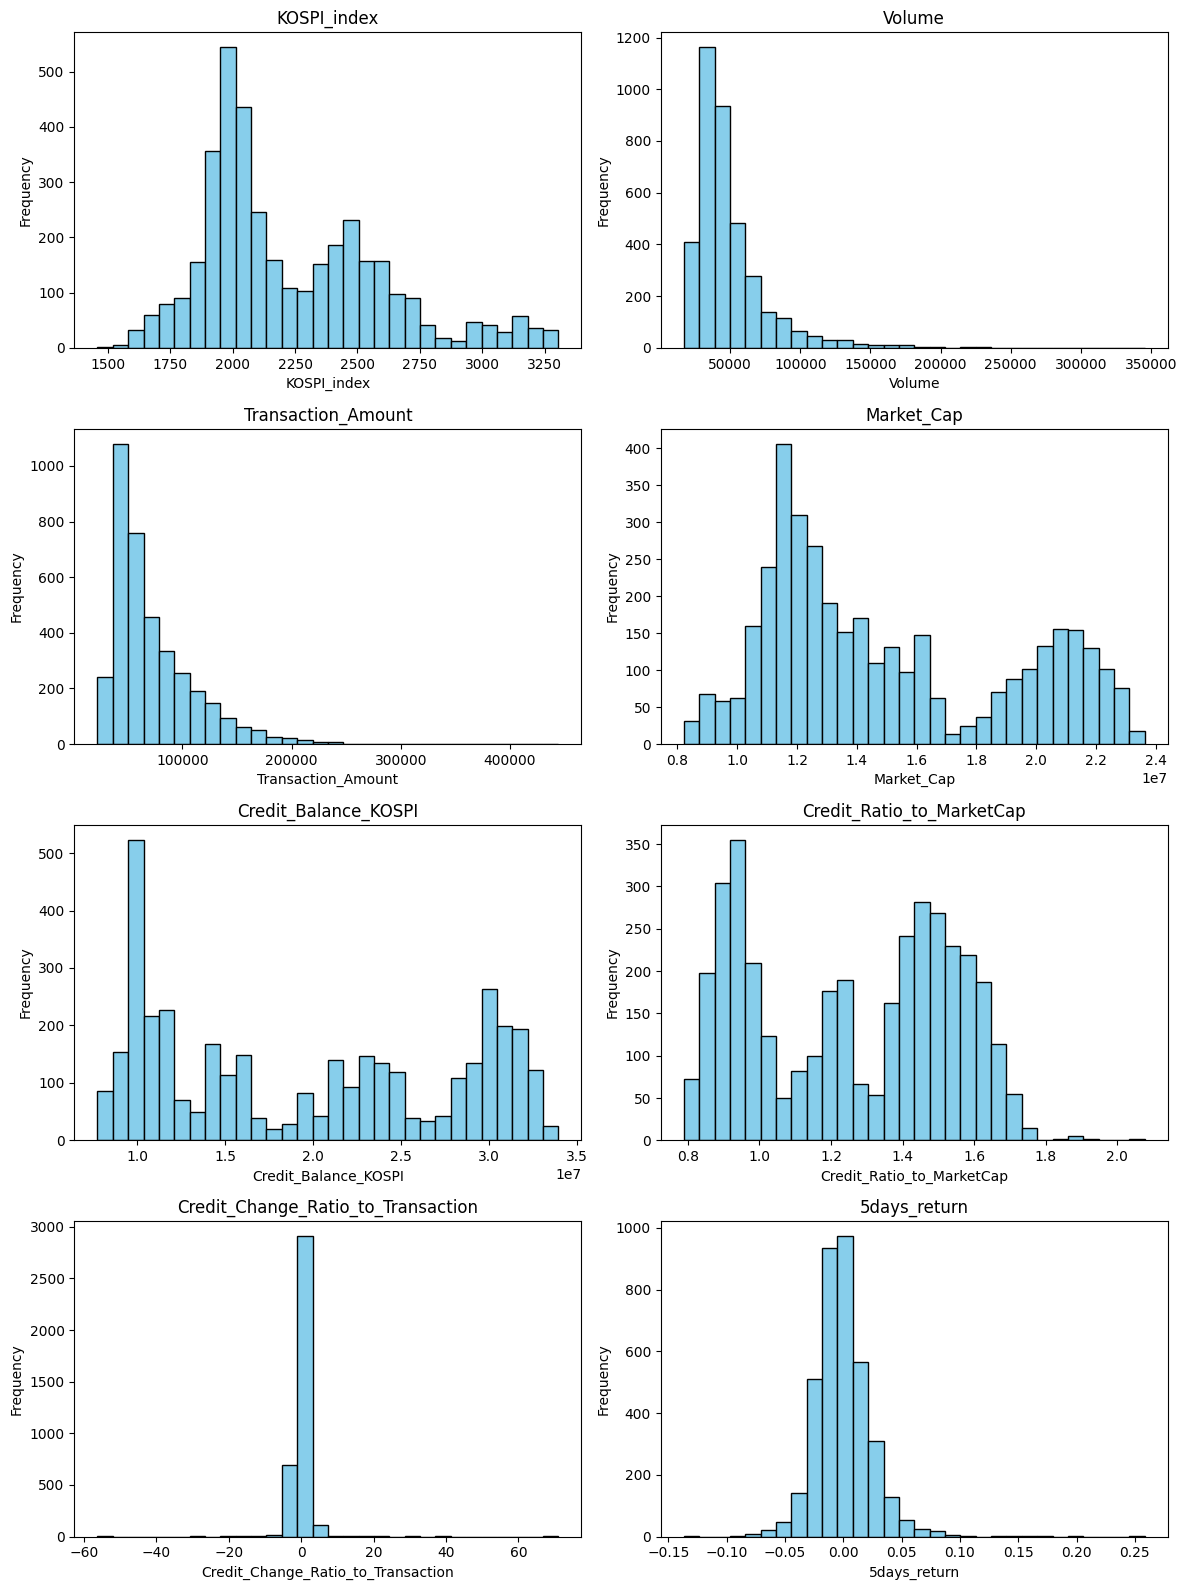

In [17]:
# 숫자형 열만 추출
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 서브플롯 설정: 한 줄에 2개씩, 전체 변수 수만큼 행 구성
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

plt.figure(figsize=(12, 4 * n_rows))  # 크기는 행 수에 따라 자동 조정

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    data = df[col].dropna()
    plt.hist(data, bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 분포에 따른 로그 정규화
| 변수명                           | 분포 특성      | 추천 변환 방법                   | 비고                                   |
|----------------------------------|:--------------|:---------------------------------|:---------------------------------------|
| KOSPI_index                      | 약간 비대칭    | 표준화(StandardScaler)           | 로그변환 불필요                        |
| Volume                           | 오른쪽 꼬리   | 로그변환(log1p) + 표준화         | log1p(0도 안전)                        |
| Transaction_Amount               | 오른쪽 꼬리   | 로그변환(log1p) + 표준화         | log1p                                  |
| Market_Cap                       | 멀티모달      | 표준화                           | 로그변환 필요성 낮음                   |
| Credit_Balance_KOSPI             | 오른쪽 꼬리   | 로그변환(log1p) + 표준화         | log1p                                  |
| Credit_Ratio_to_MarketCap        | 오른쪽 꼬리   | 표준화                           | 0~1 비율형, 로그변환 불필요            |
| Credit_Change_Ratio_to_Transaction| 꼬리 큼       | 이상치 처리(IQR 등) + 표준화      | 로그변환보단 이상치 처리 우선           |
| 5days_return                     | 대칭(정규)    | 표준화(옵션)                     | 정규분포 유사, 변환 필요 적음           |


In [29]:
df['Volume'] = np.log1p(df['Volume'])
df['Transaction_Amount'] = np.log1p(df['Transaction_Amount'])
df['Credit_Balance_KOSPI'] = np.log1p(df['Credit_Balance_KOSPI'])


scaler1= StandardScaler()
cols_to_scale = ['Volume', 'Transaction_Amount', 'Market_Cap', 'Credit_Balance_KOSPI','Credit_Ratio_to_MarketCap','5days_return']
df_scaled=pd.DataFrame(scaler1.fit_transform(df[cols_to_scale]), columns = cols_to_scale)

scaler2 = RobustScaler()
df_scaled['Credit_Change_Ratio_to_Transaction'] = scaler2.fit_transform(
    df['Credit_Change_Ratio_to_Transaction'].values.reshape(-1, 1)
)
df_scaled['Credit_Change_Ratio_to_Transaction'] = df_scaled['Credit_Change_Ratio_to_Transaction'].clip(-5, 5)
df_scaled.describe()

,Volume,Transaction_Amount,Market_Cap,Credit_Balance_KOSPI,Credit_Ratio_to_MarketCap,5days_return,Credit_Change_Ratio_to_Transaction
count,3.761000e+03,3.761000e+03,3.762000e+03,3.762000e+03,3.762000e+03,3.757000e+03,3.760000e+03
mean,1.692758e-14,3.397607e-14,-6.043957e-17,-3.209341e-14,-3.626374e-16,9.456251e-19,4.654063e-02
std,1.000133e+00,1.000133e+00,1.000133e+00,1.000133e+00,1.000133e+00,1.000133e+00,1.106496e+00
min,-2.432898e+00,-2.533968e+00,-1.664611e+00,-1.844275e+00,-1.692019e+00,-5.533417e+00,-5.000000e+00
25%,-6.770470e-01,-7.885790e-01,-8.083312e-01,-1.015029e+00,-1.065888e+00,-5.874952e-01,-4.814124e-01
50%,-1.429971e-01,-1.490278e-01,-3.393993e-01,2.212233e-01,3.157091e-02,-8.950089e-02,-9.324139e-18
75%,5.775076e-01,7.238090e-01,9.970241e-01,1.036571e+00,8.732502e-01,4.875716e-01,5.185876e-01
max,4.332737e+00,3.822723e+00,2.113959e+00,1.383558e+00,2.952350e+00,1.049626e+01,5.000000e+00


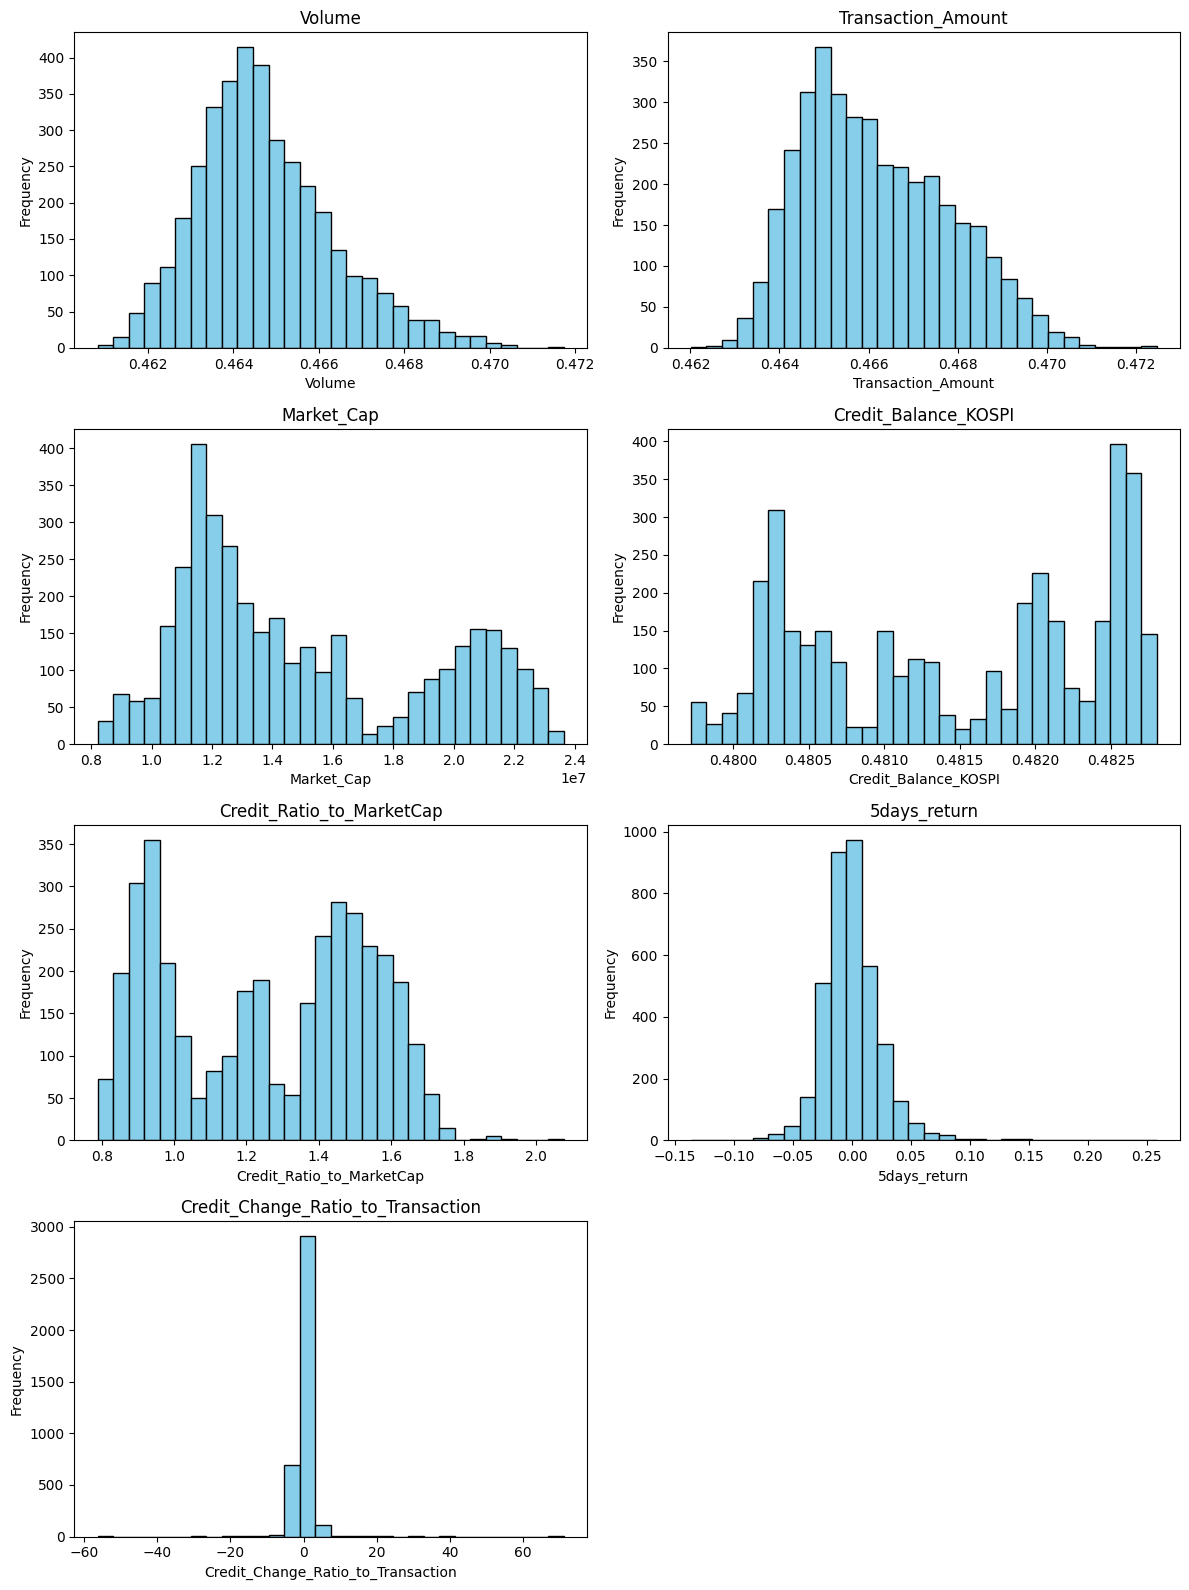

In [ ]:
# 로그 변환 및 정규화 적용 후
# 숫자형 열만 추출
numeric_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns

# 서브플롯 설정: 한 줄에 2개씩, 전체 변수 수만큼 행 구성
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

plt.figure(figsize=(12, 4 * n_rows))  # 크기는 행 수에 따라 자동 조정

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    data = df_scaled[col].dropna()
    plt.hist(data, bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()